# End-to-end machine learning project
This notebook is to do anlysis on SF Bay Area housing data. Borrowed from the following github - https://github.com/mboles01/Realestate

#### start with importing our Python libraries

In [1]:
# common imports
from pathlib import Path
import numpy as np
import pandas as pd

# sci-kit learn is our one-stop shop for machine learning!
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,  mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Exploratory Data Analysis

In [2]:
# read in the dataset
filepath = Path.joinpath(Path.cwd().parent, 'data', 'sf_bay_area_real_estate.csv')
housing = pd.read_csv(filepath)
housing.sample(5)

,Address,City,State,Zip,Price,Beds,Baths,Home_size,Lot_size,Latitude,Longitude,SF_time,PA_time,School_score,Commute_time,Price difference
3162,518 Mark Ave,Vallejo,CA,94589,398000,4,2.0,1862,5663.0,38.146033,-122.230051,98,130,28.5,98,-130432.17440
4628,2307 Lemoyne Way,Campbell,CA,95008,1649877,5,2.5,2077,5998.0,37.280635,-121.971390,100,55,52.2,55,190001.25770
3590,2732 61st Ave,Oakland,CA,94605,499000,3,1.5,1166,4275.0,37.771552,-122.187103,75,78,26.0,75,29265.79349
4217,1716 Post Ave,San Pablo,CA,94806,579000,3,2.0,1644,4680.0,37.957119,-122.352431,90,120,30.0,90,53459.91972
3128,1324 Sereno Dr,Vallejo,CA,94589,450000,3,2.0,1252,7405.0,38.129528,-122.238371,98,130,28.5,98,150686.53300


Decide what is our variable of interest (this is the item we want to predict, aka the Dependent Variable, labels, or target)

In [3]:
housing['Price'].describe()

count    5.758000e+03
mean     1.194509e+06
std      7.394026e+05
min      1.290000e+05
25%      6.790000e+05
50%      9.959750e+05
75%      1.469722e+06
max      4.999888e+06
Name: Price, dtype: float64

## Feature Engineering

In [4]:
# what are the variables?
housing.columns

Index(['Address', 'City', 'State', 'Zip', 'Price', 'Beds', 'Baths',
       'Home_size', 'Lot_size', 'Latitude', 'Longitude', 'SF_time', 'PA_time',
       'School_score', 'Commute_time', 'Price difference'],
      dtype='object')

## Prepare the data for Machine Learning algorithms

#### Get rid of missing data
Geron actually shows multiple options here (such as imputing the median) but we're just going to drop all rows with missing data.

In [5]:
# sklearn cannot handle missing data.
print(housing.isnull().sum())
# - Looks like there is no missing data
#housing.dropna(axis=1, inplace=True)

Address             0
City                0
State               0
Zip                 0
Price               0
Beds                0
Baths               0
Home_size           0
Lot_size            0
Latitude            0
Longitude           0
SF_time             0
PA_time             0
School_score        0
Commute_time        0
Price difference    0
dtype: int64


#### Feature scaling
"One of the most important transformations you need to apply to your data is feature scaling. With few exceptions, Machine Learning algorithms don’t perform well when the input numerical attributes have very different scales. This is the case for the hous‐ ing data: the total number of rooms ranges from about 6 to 39,320, while the median incomes only range from 0 to 15. Note that scaling the target values is generally not required.
There are two common ways to get all attributes to have the same scale: min-max scaling (i.e., normalization) and standardization."  -- Geron, pg. 72

"Standardization is quite different: first it subtracts the mean value (so standardized values always have a zero mean), and then it divides by the standard deviation so that the resulting distribution has unit variance. Unlike min-max scaling, standardization does not bound values to a specific range, which may be a problem for some algo‐ rithms (e.g., neural networks often expect an input value ranging from 0 to 1). However, standardization is much less affected by outliers. For example, suppose a district had a median income equal to 100 (by mistake). Min-max scaling would then crush all the other values from 0–15 down to 0–0.15, whereas standardization would not be much affected. Scikit-Learn provides a transformer called StandardScaler for standardization."  -- Geron, pg. 73

In [7]:
# What are the numeric variables in my dataset?
housing.describe().columns

Index(['Zip', 'Price', 'Beds', 'Baths', 'Home_size', 'Lot_size', 'Latitude',
       'Longitude', 'SF_time', 'PA_time', 'School_score', 'Commute_time',
       'Price difference'],
      dtype='object')

Note: Geron includes `median_house_value`(Price for us) in his scaling, but I do not. It's not actually necessary to scale your dependent variable (i.e., your target) and leaving it in the original metric makes the results a lot easier to interpret.

In [8]:
# For the purpose of scaling, make a list of only the numeric columns
numeric_cols=housing.columns.drop(['Price difference', 'Address', 'City', 'State', 'Zip', 'Price'])
print(numeric_cols)

Index(['Beds', 'Baths', 'Home_size', 'Lot_size', 'Latitude', 'Longitude',
       'SF_time', 'PA_time', 'School_score', 'Commute_time'],
      dtype='object')


Note: The following code only works because we dropped missing data earlier. This is pretty common in `sklearn` -- either drop or impute missing values at the start of your analysis!

In [9]:
# "Instantiate" the scaler (create an instance of the sklearn class)
std_scaler = StandardScaler()
std_scaler

StandardScaler()

In [10]:
# 'Fit' the scaler to our data
scaled_results = std_scaler.fit_transform(housing[numeric_cols])
scaled_results[:2]

array([[ 0.67447911, -0.37858516,  0.40562698, -0.79308001, -0.67884552,
        -0.775005  , -0.78765731, -1.52501804,  1.42310404, -1.22738988],
       [-1.67568773, -1.5658909 , -1.37879793, -0.72418137, -0.68551636,
        -0.68437749, -0.78765731, -1.52501804,  1.42310404, -1.22738988]])

In [11]:
# convert those results into a dataframe
scaled_df = pd.DataFrame(scaled_results, columns=numeric_cols)
scaled_df.head()

,Beds,Baths,Home_size,Lot_size,Latitude,Longitude,SF_time,PA_time,School_score,Commute_time
0,0.674479,-0.378585,0.405627,-0.793080,-0.678846,-0.775005,-0.787657,-1.525018,1.423104,-1.22739
1,-1.675688,-1.565891,-1.378798,-0.724181,-0.685516,-0.684377,-0.787657,-1.525018,1.423104,-1.22739
2,-0.500604,-0.378585,-0.059875,-0.438032,-0.685674,-0.841490,-0.787657,-1.525018,1.423104,-1.22739
3,0.674479,1.402373,1.284909,2.759803,-0.669992,-0.762719,-0.787657,-1.525018,1.423104,-1.22739
4,-1.675688,-1.565891,-0.952088,-0.499308,-0.700883,-0.682728,-0.787657,-1.525018,1.423104,-1.22739


In [12]:
# Drop the original numeric columns
housing = housing.drop(numeric_cols, axis=1)

In [13]:
# Merge that sub-dataframe back into the updated original housing dataframe
housing = pd.concat([housing, scaled_df], axis=1)

In [14]:
# Display a sample of those results 
housing.sample(5)

,Address,City,State,Zip,Price,Price difference,Beds,Baths,Home_size,Lot_size,Latitude,Longitude,SF_time,PA_time,School_score,Commute_time
5556,2652 Lucena Dr,San Jose,CA,95132,1138000,-143453.1345,-0.500604,-0.378585,-0.270644,-0.221075,-1.160113,1.062268,0.956430,-0.665316,0.657127,-0.221441
1570,2036 Overhill Rd,Concord,CA,94520,469000,515346.6233,-0.500604,-1.565891,-1.174494,-0.377929,1.122103,0.299153,0.770888,1.202312,-1.517424,1.270138
2582,1097 Alberdan Cir,Pinole,CA,94564,575000,-275932.6832,0.674479,-0.378585,0.134084,0.666105,1.131635,-0.829381,0.214265,1.054087,-0.874826,0.749820
4948,20372 Miljevich Dr,Saratoga,CA,95070,2998000,639285.1273,0.674479,0.215068,0.966816,1.610398,-1.627510,0.369568,0.214265,-1.198924,1.772677,-0.845823
2541,81 Heartwood Ct,Oakley,CA,94561,572000,136358.9651,-0.500604,0.215068,0.666825,0.145407,1.098427,1.808859,1.698594,1.943434,-0.792573,2.137336


#### Train-test split

"The only way to know how well a model will generalize to new cases is to actually try it out on new cases. One way to do that is to put your model in production and moni‐ tor how well it performs. This works well, but if your model is horribly bad, your users will complain—not the best idea.
A better option is to split your data into two sets: the training set and the test set. As these names imply, you train your model using the training set, and you test it using the test set. The error rate on new cases is called the generalization error (or out-of- sample error), and by evaluating your model on the test set, you get an estimate of this error. This value tells you how well your model will perform on instances it has never seen before."  -- Geron, pg. 31

In [15]:
# First, split your data into features (X) and labels (y).
y = housing["Price"].copy()
X = housing.drop(["Price", "Address", "City", "State", "Zip", "Price difference"], axis=1)
# Compare their shapes.
print(y.shape)
print(X.shape)

(5758,)
(5758, 10)


In [16]:
# Now, split both X and y data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                       test_size=0.2, 
                                       random_state=42)

In [17]:
# Compare the shapes to confirm this did what you wanted.
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4606, 10)
(4606,)
(1152, 10)
(1152,)


## Select and train a model

In [18]:
# Create a local instance of the sklearn class, and show its options
lin_reg = LinearRegression()
lin_reg

LinearRegression()

In [19]:
# Fit your instance to the training dataset
lin_reg.fit(X_train, y_train)

LinearRegression()

In [20]:
# display the intercept
lin_reg.intercept_

1192608.922903277

In [21]:
# display coefficients
lin_reg.coef_

array([ -65816.92292443,   85801.84843159,  330677.45784646,
        100225.50609841,  -71124.48622073,  -45930.04952065,
         90588.77790296,   75166.67656337,  164050.59382731,
       -473794.1805488 ])

In [22]:
# Display intercept and coefficients as a dataframe
cols=list(X_train.columns)
coefs=list(lin_reg.coef_)
coefs=[int(x) for x in coefs]
# add the intercept
cols.insert(0, "intercept")
coefs.insert(0, int(lin_reg.intercept_))
# combine into a dataframe
regression_components = pd.DataFrame(coefs, cols, columns=['coefficients'])
regression_components 

,coefficients
intercept,1192608
Beds,-65816
Baths,85801
Home_size,330677
Lot_size,100225
Latitude,-71124
Longitude,-45930
SF_time,90588
PA_time,75166
School_score,164050


In [24]:
# what is the equation for this model?

xcoefs = [(coefs[i], cols[i]) for i in range(0, len(cols))]

output = f"""y =  {round(lin_reg.intercept_,2)} + 
                {round(xcoefs[0][0],2)}*{xcoefs[0][1]} + 
                {round(xcoefs[1][0],2)}*{xcoefs[1][1]} + 
                {round(xcoefs[2][0],2)}*{xcoefs[2][1]} + 
                {round(xcoefs[3][0],2)}*{xcoefs[3][1]} + 
                {round(xcoefs[4][0],2)}*{xcoefs[4][1]} + 
                {round(xcoefs[5][0],2)}*{xcoefs[5][1]} + 
                {round(xcoefs[6][0],2)}*{xcoefs[6][1]} + 
                {round(xcoefs[7][0],2)}*{xcoefs[7][1]} + 
                {round(xcoefs[8][0],2)}*{xcoefs[8][1]} +
                {round(xcoefs[9][0],2)}*{xcoefs[9][1]} + 
                {round(xcoefs[10][0],2)}*{xcoefs[10][1]}
                """
print("Regression Equation: ", "\n", output)  

Regression Equation:  
 y =  1192608.92 + 
                1192608*intercept + 
                -65816*Beds + 
                85801*Baths + 
                330677*Home_size + 
                100225*Lot_size + 
                -71124*Latitude + 
                -45930*Longitude + 
                90588*SF_time + 
                75166*PA_time +
                164050*School_score + 
                -473794*Commute_time
                


## Make predictions on your testing dataset

In [25]:
# Make predictions on the testing dataset
y_preds = lin_reg.predict(X_test)

In [26]:
# Examine your predictions
y_preds

array([ 445005.80881083, 1451233.40536476,  390386.78775281, ...,
       2520824.61058182,  919236.98041353, 1556969.47920302])

In [27]:
# How do the first five predictions compare to the first five actual values?
true_5=list(round(y_test[:5], 1))
pred_5=[round(x,1) for x in list(y_preds[:5])]
print('true values:', true_5)
print('predicted values:', pred_5)

true values: [398000, 1649877, 499000, 579000, 450000]
predicted values: [445005.8, 1451233.4, 390386.8, 571076.4, 318864.1]


In [28]:
# How do we intepret those results?
first_5=['house0', 'house1', 'house2', 'house3', 'house4']
pd.DataFrame(list(zip(first_5, true_5, pred_5)), columns=['house', 'true', 'predicted'])

,house,true,predicted
0,house0,398000,445005.8
1,house1,1649877,1451233.4
2,house2,499000,390386.8
3,house3,579000,571076.4
4,house4,450000,318864.1


## Examine the feature importances

In [29]:
# 'Attributes' is another name for our list of features (aka predictors, independent variables)
attributes=X_test.columns
print(attributes)
# 'Feature importances' is another name for our coefficients (ie., the impace of each feature on the outcome or DV)
feature_importances=lin_reg.coef_
print(feature_importances)

Index(['Beds', 'Baths', 'Home_size', 'Lot_size', 'Latitude', 'Longitude',
       'SF_time', 'PA_time', 'School_score', 'Commute_time'],
      dtype='object')
[ -65816.92292443   85801.84843159  330677.45784646  100225.50609841
  -71124.48622073  -45930.04952065   90588.77790296   75166.67656337
  164050.59382731 -473794.1805488 ]


In [30]:
# obviously, these 2 things will have the same length
print(len(feature_importances))
print(len(attributes))

10
10


In [31]:
[int(x) for x in list(feature_importances)]

[-65816, 85801, 330677, 100225, -71124, -45930, 90588, 75166, 164050, -473794]

In [32]:
# let's take a look at the results
feature_imp = pd.DataFrame(list(zip(attributes, feature_importances)), columns=['features', 'coeffs'])
feature_imp=feature_imp.set_index('features')
feature_imp=feature_imp.sort_values('coeffs')
feature_imp

,coeffs
features,
Commute_time,-473794.180549
Latitude,-71124.486221
Beds,-65816.922924
Longitude,-45930.049521
PA_time,75166.676563
Baths,85801.848432
SF_time,90588.777903
Lot_size,100225.506098
School_score,164050.593827


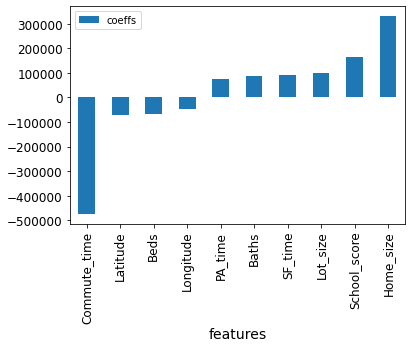

In [33]:
# plot that as a bar chart
feature_imp.plot(kind='bar');

## Evaluate your model

In [34]:
# root mean squared error represents the average error (in $) of our model
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_preds))
round(rmse,2)

376826.19

In [35]:
# how does this compare to the mean of our training set?
avg_val = round(y_train.mean(),2)
avg_val

1193260.55

In [36]:
# If we used that as our predictor, then the average error of our model would be:
comparison_array=np.full((len(y_test), ), avg_val)
coin_flip=np.sqrt(metrics.mean_squared_error(y_test, comparison_array))
print(round(coin_flip))

748698


In [37]:
# R-squared is another important metric
r2=metrics.r2_score(y_test, y_preds)
round(r2, 2)

0.75

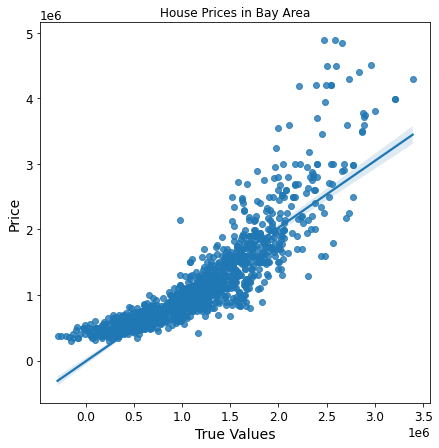

In [38]:
# Visualize our true vs. predicted values
import seaborn as sns
plt.figure(figsize=(7,7))
plt.title('House Prices in Bay Area')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
fig=sns.regplot(x=y_preds, y=y_test)
plt.show(fig)